In [33]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('training.csv')
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array


    

Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Epoch 1/60
27/27 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.5181
Epoch 1: val_loss improved from inf to 0.01498, saving model to checkpoint1.hdf5
27/27 [==============================] - 5s 157ms/step - loss: 0.0539 - accuracy: 0.5181 - val_loss: 0.0150 - val_accuracy: 0.3995
Epoch 2/60
 1/27 [>.............................] - ETA: 3s - loss: 0.0160 - accuracy: 0.3594

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.5648
Epoch 2: val_loss improved from 0.01498 to 0.00870, saving model to checkpoint1.hdf5
27/27 [==============================] - 4s 153ms/step - loss: 0.0107 - accuracy: 0.5648 - val_loss: 0.0087 - val_accuracy: 0.4322
Epoch 3/60
27/27 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.6676
Epoch 3: val_loss improved from 0.00870 to 0.00782, saving model to checkpoint1.hdf5
27/27 [==============================] - 4s 153ms/step - loss: 0.0073 - accuracy: 0.6676 - val_loss: 0.0078 - val_accuracy: 0.4322
Epoch 4/60
27/27 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.6846
Epoch 4: val_loss improved from 0.00782 to 0.00775, saving model to checkpoint1.hdf5
27/27 [==============================] - 5s 168ms/step - loss: 0.0063 - accuracy: 0.6846 - val_loss: 0.0078 - val_accuracy: 0.4322
Epoch 5/60
27/27 [==============================] - ETA: 0s - loss: 0.0059 - accu

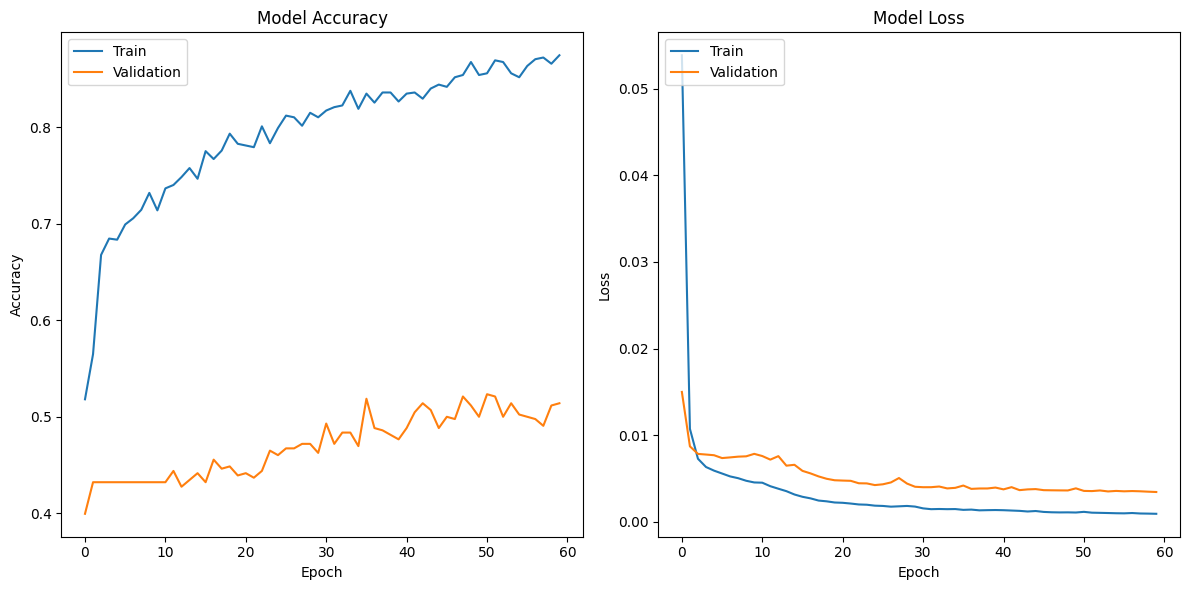

In [36]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
from copy import deepcopy 
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # Change the output layer to have 136 units
    model.add(Dense(30, activation='linear'))
    
    return model




X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model for the first time
model_fit_before = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('model1.h5')

# Define the plot_training_history function
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Plot the combined training history
plot_training_history(hist)

1/1 [==============================] - 0s 90ms/step


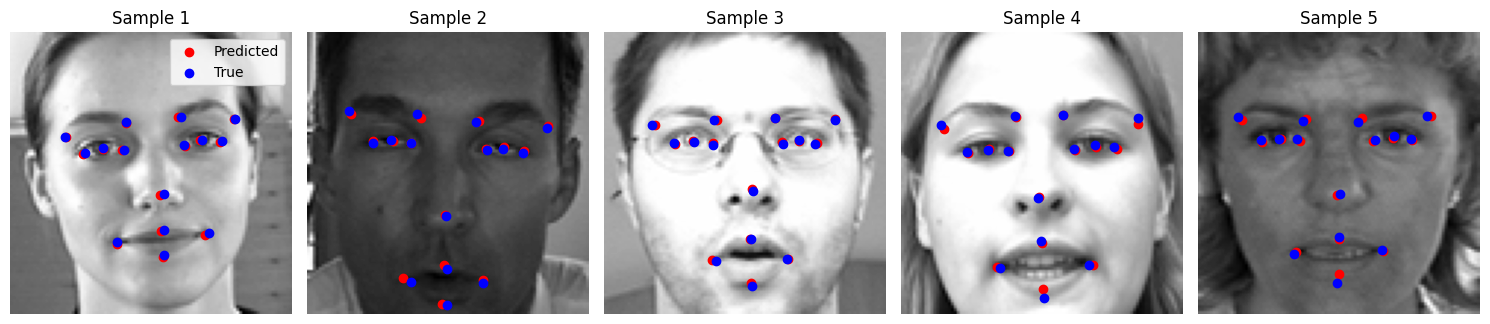

In [41]:
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, X_test, y_test):
    # Randomly select some samples from the test set
    sample_indexes = random.sample(range(X_test.shape[0]), 5)

    # Make predictions on the selected samples
    predictions = model.predict(X_test[sample_indexes])

    # Rescale the keypoints to the original scale (48x48)
    predictions_rescaled = predictions * 48 + 48
    y_test_rescaled = y_test[sample_indexes] * 48 + 48

    # Plot the images with predicted keypoints
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # Adjust the figsize for larger images
    for i, (index, ax) in enumerate(zip(sample_indexes, axes)):
        ax.imshow(X_test[index].reshape(96, 96), cmap='gray')
        ax.scatter(predictions_rescaled[i][0::2], predictions_rescaled[i][1::2], marker='o', color='r', label='Predicted')
        ax.scatter(y_test_rescaled[i][0::2], y_test_rescaled[i][1::2], marker='o', color='b', label='True')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

        # Add legend
        if i == 0:
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Load the trained model
trained_model = load_model('model1.h5')

# Visualize predictions on a few test samples
visualize_predictions(trained_model, X_train, y_train)


1/1 [==============================] - 0s 91ms/step


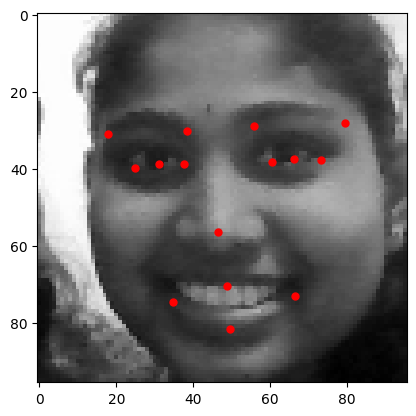

1/1 [==============================] - 0s 16ms/step


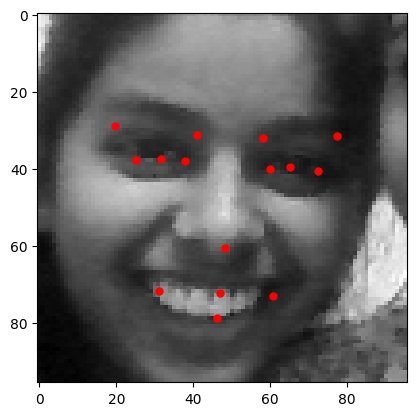

1/1 [==============================] - 0s 26ms/step


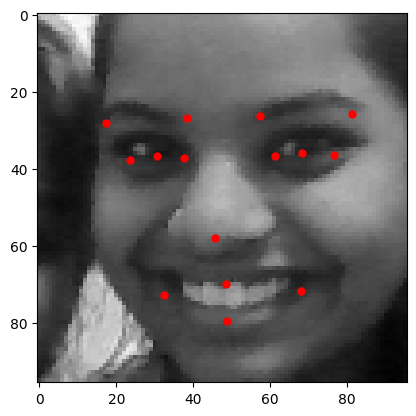

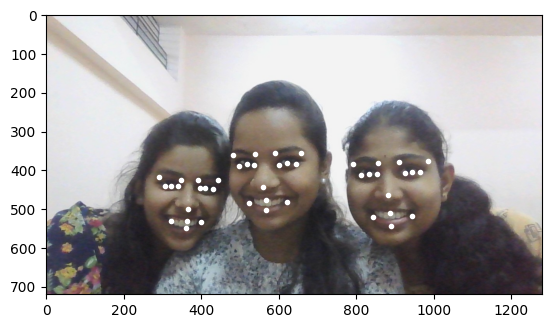

In [38]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'model1.h5'  # <-- Update with your actual model path
try:
    model = load_model(model_path)
except Exception as e:
    print(f"Error loading the model from {model_path}: {str(e)}")
    # Handle the error (e.g., exit the script)

def detect_points(face_img):
    me = np.array(face_img) / 255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    try:
        y_test = model.predict(x_test)
    except Exception as e:
        print(f"Error predicting with the model: {str(e)}")
        # Handle the error (e.g., exit the script)

    label_points = (np.squeeze(y_test) * 48) + 48
    
    return label_points

# Load haarcascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img_path = r"C:\Users\Lenovo\OneDrive\Pictures\Camera Roll\WIN_20230105_15_40_11_Pro.jpg"
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Unable to load the image from {img_path}")
    # Handle the error (e.g., exit the script)

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False

all_x_cords = []
all_y_cords = []

for i, (x, y, w, h) in enumerate(faces):
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h, x:x+w], dimensions)
    cv2.rectangle(faces_img, (x, y), (x+w, y+h), (255, 0, 0), 1)
    
    scale_val_x = w / 96
    scale_val_y = h / 96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2] * scale_val_x) + x)
    all_y_cords.append((label_point[1::2] * scale_val_y) + y)
    
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()

plt.imshow(default_img)
plt.plot(all_x_cords, all_y_cords, 'wo', markersize=3)
plt.show()


In [46]:
from keras.models import load_model
import numpy as np
import cv2
import time

# Load the saved model
model = load_model('model1.h5')  # <-- Saved model path

# Load haarcascade for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Open the default camera (usually the built-in webcam)
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Get the frames per second (fps) of the camera
fps = cap.get(cv2.CAP_PROP_FPS)

# Create an output video file
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
output_filename = 'output_video.avi'
out = cv2.VideoWriter(output_filename, fourcc, fps, dimensions, isColor=True)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Error reading frame.")
        break

    # Convert the frame to grayscale for face detection
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)

    for (x, y, w, h) in faces:
        # Extract the face region
        face_roi = gray_img[y:y + h, x:x + w]

        # Resize the face image to match the input size of your model
        face_input = cv2.resize(face_roi, dimensions)
        face_input = np.expand_dims(np.expand_dims(face_input, axis=0), axis=-1)

        # Normalize the input
        face_input = face_input / 255.0

        # Predict facial landmarks using your model
        landmarks = model.predict(face_input)
        landmarks = (landmarks.squeeze() * 48) + 48

        # Draw landmarks on the face
        for i in range(0, len(landmarks), 2):
            cv2.circle(frame, (int(landmarks[i] * (w / 96) + x), int(landmarks[i + 1] * (h / 96) + y)), 2, (0, 255, 0),
                       -1)

        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow('Facial Landmarks Detection', frame)

    # Write the frame to the output video file
    out.write(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera, output video file, and close all windows
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 15ms/step


KeyboardInterrupt: 